# PVNet – Possession Value Network (training only in Colab)

This notebook:
1) mount Google Drive
2) download/upload StatsBomb Open Data
3) create event datasets with feature engineering
4) define labels: shot_within_K and goal_within_K
5) split per match (train/val/test)
6) train PyTorch multitask (shot + goal)
7) evaluate and save:
   - artifacts/model.pth
   - artifacts/metrics.json
   - artifacts/test_predictions.parquet



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
from pathlib import Path

PROJECT_ROOT = Path("/content/drive/MyDrive/pvnet-football")
SRC_ROOT = PROJECT_ROOT / "src"
ARTIFACTS_DIR = PROJECT_ROOT / "artifacts"

ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

if str(SRC_ROOT) not in sys.path:
    sys.path.append(str(SRC_ROOT))

print("PROJECT_ROOT:", PROJECT_ROOT)
print("SRC_ROOT:", SRC_ROOT)
print("ARTIFACTS_DIR:", ARTIFACTS_DIR)


Mounted at /content/drive
PROJECT_ROOT: /content/drive/MyDrive/pvnet-football
SRC_ROOT: /content/drive/MyDrive/pvnet-football/src
ARTIFACTS_DIR: /content/drive/MyDrive/pvnet-football/artifacts


In [ ]:
!pip -q install statsbombpy pandas numpy scikit-learn pyarrow fastparquet matplotlib torch tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 85.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 8.3 MB/s eta 0:00:00


In [ ]:
from config import Config
from data.load_statsbomb import load_competition_events
from data.preprocessing import basic_clean, build_features
from data.labeling import add_future_labels
from data.split import split_by_match
from training.utils import set_seed, get_device

cfg = Config()
set_seed(cfg.RANDOM_SEED)
device = get_device()
print("Device:", device)


Device: cuda


In [ ]:
from statsbombpy import sb
comps = sb.competitions()
comps[["competition_id","season_id","competition_name","season_name","country_name"]].sort_values(
    ["competition_name","season_id"], ascending=[True, False]
).head(60)


/usr/local/lib/python3.12/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


,competition_id,season_id,competition_name,season_name,country_name
0,9,281,1. Bundesliga,2023/2024,Germany
1,9,27,1. Bundesliga,2015/2016,Germany
2,1267,107,African Cup of Nations,2023,Africa
18,16,277,Champions League,1972/1973,Europe
20,16,276,Champions League,1970/1971,Europe
17,16,76,Champions League,1999/2000,Europe
19,16,71,Champions League,1971/1972,Europe
16,16,44,Champions League,2003/2004,Europe
13,16,41,Champions League,2008/2009,Europe
14,16,39,Champions League,2006/2007,Europe


In [ ]:
import pandas as pd

COMPETITIONS = [
    # Examples: replace with those found in comps
    (223, 282),   # Copa America 2024
    (1267, 107),  # Africa Cup of Nations
    (43, 106),  # FIFA World Cup 2022
    (16, 4)   # Champions League 2018/2019
]

all_events = []
for comp_id, season_id in COMPETITIONS:
    try:
        ev = load_competition_events(comp_id, season_id, include_freeze_frame=False)
        ev["competition_id"] = comp_id
        ev["season_id"] = season_id
        all_events.append(ev)
        print(f"OK -> comp={comp_id}, season={season_id}, rows={len(ev)}")
    except Exception as e:
        print(f"SKIP -> comp={comp_id}, season={season_id} | {type(e).__name__}: {e}")

events_raw = pd.concat(all_events, ignore_index=True)
print("TOTAL events_raw:", events_raw.shape)
events_raw.head(3)


/usr/local/lib/python3.12/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsbombpy/api_client.py:21: 

OK -> comp=223, season=282, rows=100305


/usr/local/lib/python3.12/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsbombpy/api_client.py:21: 

OK -> comp=1267, season=107, rows=162910


/usr/local/lib/python3.12/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsbombpy/api_client.py:21: 

OK -> comp=43, season=106, rows=234652


/usr/local/lib/python3.12/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


OK -> comp=16, season=4, rows=3165
TOTAL events_raw: (501032, 117)


,50_50,bad_behaviour_card,ball_receipt_outcome,ball_recovery_offensive,ball_recovery_recovery_failure,block_deflection,block_offensive,carry_end_location,clearance_aerial_won,clearance_body_part,...,goalkeeper_penalty_saved_to_post,shot_open_goal,competition_id,season_id,goalkeeper_shot_saved_off_target,shot_saved_off_target,player_off_permanent,shot_follows_dribble,half_start_late_video_start,goalkeeper_success_in_play
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,223,282,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,223,282,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,223,282,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df = basic_clean(events_raw)
df = build_features(df)
df = add_future_labels(df, k=cfg.K_FUTURE_EVENTS)

# optional: only keep events with locations
df = df[df["location"].notna()].reset_index(drop=True)

print(df.shape)
print(df[["shot_within_k","goal_within_k"]].mean())
print(df["match_id"].nunique())

df[["type_name","shot_within_k","goal_within_k"]].value_counts().head(10)


(495735, 141)
shot_within_k    0.051511
goal_within_k    0.005301
dtype: float64
149


,,,count
type_name,shot_within_k,goal_within_k,
Pass,0,0,135405
Ball Receipt*,0,0,126172
Carry,0,0,105077
Pressure,0,0,38588
Ball Recovery,0,0,12216
Duel,0,0,9042
Ball Receipt*,1,0,5808
Pass,1,0,5679
Clearance,0,0,5650


In [ ]:
import numpy as np

FEATURE_COLS = [
    "start_x","start_y","end_x","end_y",
    "dist_to_goal","angle_to_goal_center",
    "dx","dy","progress_x",
    "time_seconds",
    "is_pass","is_carry","is_dribble","is_shot",
    "pass_success","dribble_success",
]

X = df[FEATURE_COLS].astype(float).values
y_shot = df["shot_within_k"].astype(int).values
y_goal = df["goal_within_k"].astype(int).values

print("X:", X.shape, "shot pos_rate:", y_shot.mean(), "goal pos_rate:", y_goal.mean())


X: (495735, 16) shot pos_rate: 0.051511392175254925 goal pos_rate: 0.00530121940149475


In [ ]:
train_df, val_df, test_df = split_by_match(
    df,
    train_frac=cfg.TRAIN_FRAC,
    val_frac=cfg.VAL_FRAC,
    test_frac=cfg.TEST_FRAC,
    seed=cfg.RANDOM_SEED
)

def to_xy(d):
    Xd = d[FEATURE_COLS].astype(float).values
    ys = d["shot_within_k"].astype(int).values
    yg = d["goal_within_k"].astype(int).values
    return Xd, ys, yg

X_train, y_train_shot, y_train_goal = to_xy(train_df)
X_val, y_val_shot, y_val_goal = to_xy(val_df)
X_test, y_test_shot, y_test_goal = to_xy(test_df)

X_train.shape, X_val.shape, X_test.shape


((343852, 16), (75289, 16), (76594, 16))

In [ ]:
from sklearn.preprocessing import StandardScaler
import joblib

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)

SCALER_PATH = ARTIFACTS_DIR / "scaler.joblib"
joblib.dump(scaler, SCALER_PATH)
print("Saved scaler:", SCALER_PATH)


Saved scaler: /content/drive/MyDrive/pvnet-football/artifacts/scaler.joblib


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

from models.pvnet import PVNet
from training.train_loop import make_loader, train_one_epoch, eval_one_epoch

train_loader = make_loader(X_train_s, y_train_shot, y_train_goal, batch_size=cfg.BATCH_SIZE, shuffle=True)
val_loader   = make_loader(X_val_s, y_val_shot, y_val_goal, batch_size=cfg.BATCH_SIZE, shuffle=False)
test_loader  = make_loader(X_test_s, y_test_shot, y_test_goal, batch_size=cfg.BATCH_SIZE, shuffle=False)

model = PVNet(in_dim=X_train_s.shape[1], hidden_dim=cfg.HIDDEN_DIM, dropout=cfg.DROPOUT).to(device)

pos_shot = train_df["shot_within_k"].mean()
pos_goal = train_df["goal_within_k"].mean()

pos_weight_shot = float((1.0 - pos_shot) / max(pos_shot, 1e-6))
pos_weight_goal = float((1.0 - pos_goal) / max(pos_goal, 1e-6))

criterion = torch.nn.BCEWithLogitsLoss()
criterion.to(device)

optimizer = optim.AdamW(model.parameters(), lr=cfg.LR, weight_decay=cfg.WEIGHT_DECAY)

print(model)


PVNet(
  (net): Sequential(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.15, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.15, inplace=False)
    (6): Linear(in_features=128, out_features=2, bias=True)
  )
)


In [ ]:
from tqdm import tqdm

best_val = float("inf")
best_state = None
pat = 0

history = []

for epoch in range(1, cfg.EPOCHS + 1):
    tr_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    va_loss, va_logits, va_y = eval_one_epoch(model, val_loader, criterion, device)

    history.append({"epoch": epoch, "train_loss": tr_loss, "val_loss": va_loss})
    print(f"Epoch {epoch:02d} | train_loss={tr_loss:.5f} | val_loss={va_loss:.5f}")

    if va_loss < best_val - 1e-5:
        best_val = va_loss
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        pat = 0
    else:
        pat += 1
        if pat >= cfg.EARLY_STOPPING_PATIENCE:
            print("Early stopping.")
            break

model.load_state_dict(best_state)
print("Best val_loss:", best_val)


Epoch 01 | train_loss=0.20413 | val_loss=0.11373
Epoch 02 | train_loss=0.11460 | val_loss=0.10564
Epoch 03 | train_loss=0.10795 | val_loss=0.10004
Epoch 04 | train_loss=0.10416 | val_loss=0.09775
Epoch 05 | train_loss=0.10277 | val_loss=0.09674
Epoch 06 | train_loss=0.10212 | val_loss=0.09634
Epoch 07 | train_loss=0.10166 | val_loss=0.09605
Epoch 08 | train_loss=0.10107 | val_loss=0.09586
Epoch 09 | train_loss=0.10076 | val_loss=0.09565
Epoch 10 | train_loss=0.10051 | val_loss=0.09554
Epoch 11 | train_loss=0.10036 | val_loss=0.09545
Epoch 12 | train_loss=0.10034 | val_loss=0.09534
Best val_loss: 0.09534443362200087


In [ ]:
from training.evaluate import compute_metrics, calibration_data
import json
from pathlib import Path # Import Path to check for PosixPath objects

test_loss, test_logits, test_y = eval_one_epoch(model, test_loader, criterion, device)
metrics, test_probs = compute_metrics(test_logits, test_y)
calib = calibration_data(test_probs, test_y, n_bins=10)

# Create a serializable version of cfg.__dict__
serializable_config = {}
for k, v in cfg.__dict__.items():
    if isinstance(v, Path): # Check if the value is a Path object
        serializable_config[k] = str(v) # Convert Path to string
    else:
        serializable_config[k] = v

out = {
    "test_loss": float(test_loss),
    "metrics": metrics,
    "calibration": calib,
    "config": serializable_config, # Use the serializable_config here
    "feature_cols": FEATURE_COLS,
}

METRICS_PATH = ARTIFACTS_DIR / "metrics.json"
with open(METRICS_PATH, "w") as f:
    json.dump(out, f, indent=2)

print("Saved metrics:", METRICS_PATH)
print(json.dumps(metrics, indent=2))


Saved metrics: /content/drive/MyDrive/pvnet-football/artifacts/metrics.json
{
  "shot": {
    "roc_auc": 0.8092229142679036,
    "pr_auc": 0.26792545900320386,
    "log_loss": 0.15638420192683306,
    "brier": 0.03971366269298691,
    "pos_rate": 0.047444969579862654
  },
  "goal": {
    "roc_auc": 0.8238402060697785,
    "pr_auc": 0.05130464295103074,
    "log_loss": 0.026144882236405303,
    "brier": 0.004640812739714014,
    "pos_rate": 0.004765386322688461
  }
}


In [ ]:
import numpy as np
import pandas as pd
import torch

# =========================
# 1) Build test_out + probs
# =========================
test_out = test_df.copy().reset_index(drop=True)

test_out["p_shot"] = test_probs[:, 0]
test_out["p_goal"] = test_probs[:, 1]

# minute bucket for timeline charts
if "minute" in test_out.columns:
    test_out["minute_bucket"] = test_out["minute"].astype(float).fillna(0).astype(int)
else:
    # fallback: build from seconds if available
    if "second" in test_out.columns:
        test_out["minute_bucket"] = (test_out["second"] // 60).astype(int)
    else:
        test_out["minute_bucket"] = 0


test_feat = test_df[FEATURE_COLS].astype(float).values
test_feat_s = scaler.transform(test_feat)

# =========================
# 2) State BEFORE (prev event in same match+possession)
# =========================
prev_idx = (
    test_out.index.to_series()
        .groupby([test_out["match_id"], test_out["possession"]])
        .shift(1)
)
prev_idx = prev_idx.fillna(-1).astype(int).values

X_before = test_feat_s.copy()
mask = prev_idx >= 0
X_before[mask] = test_feat_s[prev_idx[mask]]

model.eval()
with torch.no_grad():
    logits_before = model(torch.tensor(X_before, dtype=torch.float32).to(device)).cpu().numpy()

p_before = 1 / (1 + np.exp(-logits_before))
test_out["p_shot_before"] = p_before[:, 0]
test_out["p_goal_before"] = p_before[:, 1]

# =========================
# 3) Action value (CURRENT - BEFORE)
# =========================
w_goal = 5.0  # (poi lo spostiamo in cfg)
V_before = test_out["p_shot_before"] + w_goal * test_out["p_goal_before"]
V_curr   = test_out["p_shot"]        + w_goal * test_out["p_goal"]

test_out["action_value_raw"] = (V_curr - V_before)

# =========================
# 3.1) FIX 2 — Dashboard-friendly value (don't hide shot/goal actions)
# =========================
# Base: keep standard "movement" actions WITH an end_location (Pass/Carry/Dribble/Shot)
VALID_ACTIONS = {"Pass", "Carry", "Dribble", "Shot"}

is_valid_action = test_out["type_name"].isin(VALID_ACTIONS)

has_end = (
    test_out.get("pass_end_location", pd.Series(False, index=test_out.index)).notna()
    | test_out.get("carry_end_location", pd.Series(False, index=test_out.index)).notna()
    | test_out.get("shot_end_location", pd.Series(False, index=test_out.index)).notna()
).fillna(False)

base_mask = is_valid_action & has_end

# Extra: ALWAYS keep actions that are labeled as leading to shot/goal (so they can show up in Top Actions)
label_mask = (
    (test_out.get("shot_within_k", 0) == 1) |
    (test_out.get("goal_within_k", 0) == 1)
)

# Compose dashboard value
test_out["action_value_dashboard"] = np.where(
    base_mask | label_mask,
    test_out["action_value_raw"],
    0.0
)

# Optional: remove tiny noise but DO NOT clip negatives asymmetrically
eps = 0.005
test_out.loc[test_out["action_value_dashboard"].abs() < eps, "action_value_dashboard"] = 0.0

# Convenience columns used later in ranking
test_out["value_pos"] = test_out["action_value_dashboard"].clip(lower=0.0)
test_out["value_neg"] = test_out["action_value_dashboard"].clip(upper=0.0)

# =========================
# 4) Save test predictions
# =========================
PRED_PATH = ARTIFACTS_DIR / "test_predictions.parquet"
test_out.to_parquet(PRED_PATH, index=False)

# =========================
# 5) Ranking player (outfield vs GK-like proxy)
# =========================
actions_df = test_out[test_out["action_value_dashboard"] != 0.0].copy()

# Ranking più "attaccante": solo azioni in metà campo offensiva o fortemente progressive
actions_for_ranking = actions_df[
    (actions_df["start_x"] >= 60) | (actions_df["progress_x"] >= 5) | (actions_df["end_x"] >= 80)
].copy()

player_depth = (
    actions_for_ranking.assign(is_deep=(actions_for_ranking["start_x"] < 20).astype(int))
    .groupby(["player_name", "team_name"])["is_deep"]
    .mean()
    .reset_index()
    .rename(columns={"is_deep": "deep_action_rate"})
)

player_ranking = (
    actions_for_ranking.groupby(["player_name", "team_name"], dropna=False)
    .agg(
        value_total=("action_value_dashboard", "sum"),
        actions=("action_value_dashboard", "size"),
        value_mean=("action_value_dashboard", "mean"),
        value_median=("action_value_dashboard", "median"),
        value_pos_total=("value_pos", "sum"),
        value_neg_total=("value_neg", "sum"),
    )
    .reset_index()
    .merge(player_depth, on=["player_name", "team_name"], how="left")
)

player_ranking["value_per_100_actions"] = player_ranking["value_total"] * (100.0 / player_ranking["actions"].clip(lower=1))
player_ranking["is_reliable"] = player_ranking["actions"] >= 50

OUTFIELD_MAX_DEEP_RATE = 0.60
outfield = player_ranking[player_ranking["deep_action_rate"] <= OUTFIELD_MAX_DEEP_RATE].copy()
gk_like  = player_ranking[player_ranking["deep_action_rate"] >  OUTFIELD_MAX_DEEP_RATE].copy()

OUTFIELD_PATH = ARTIFACTS_DIR / "player_ranking_outfield.parquet"
GK_PATH = ARTIFACTS_DIR / "player_ranking_goalkeepers.parquet"
outfield.to_parquet(OUTFIELD_PATH, index=False)
gk_like.to_parquet(GK_PATH, index=False)

# =========================
# 6) Team match ranking
# =========================
team_match = (
    actions_for_ranking.groupby(["match_id", "team_name"], dropna=False)
    .agg(
        team_value_total=("action_value_dashboard", "sum"),
        actions=("action_value_dashboard", "size"),
        team_value_per_100=("action_value_dashboard", lambda s: s.sum() * (100.0 / max(len(s), 1))),
    )
    .reset_index()
)
TEAM_MATCH_PATH = ARTIFACTS_DIR / "team_match_ranking.parquet"
team_match.to_parquet(TEAM_MATCH_PATH, index=False)

print("Saved test predictions:", PRED_PATH)
print("Saved outfield ranking:", OUTFIELD_PATH)
print("Saved GK-like ranking:", GK_PATH)
print("Saved team-match ranking:", TEAM_MATCH_PATH)

display(test_out[["type_name","player_name","team_name","p_shot","p_goal","action_value_dashboard"]].head(12))
display(outfield[outfield["is_reliable"]].sort_values("value_per_100_actions", ascending=False).head(15))


Saved test predictions: /content/drive/MyDrive/pvnet-football/artifacts/test_predictions.parquet
Saved outfield ranking: /content/drive/MyDrive/pvnet-football/artifacts/player_ranking_outfield.parquet
Saved GK-like ranking: /content/drive/MyDrive/pvnet-football/artifacts/player_ranking_goalkeepers.parquet
Saved team-match ranking: /content/drive/MyDrive/pvnet-football/artifacts/team_match_ranking.parquet


,type_name,player_name,team_name,p_shot,p_goal,action_value_dashboard
0,Pass,Aleksandar Mitrović,Serbia,0.007996,0.000394,0.000000
1,Ball Receipt*,Saša Lukić,Serbia,0.020807,0.002167,0.000000
2,Carry,Saša Lukić,Serbia,0.007098,0.000386,-0.022612
3,Pass,Saša Lukić,Serbia,0.002420,0.000068,-0.006269
4,Ball Receipt*,Strahinja Pavlović,Serbia,0.016129,0.001331,0.000000
5,Carry,Strahinja Pavlović,Serbia,0.003877,0.000174,-0.018036
6,Pass,Strahinja Pavlović,Serbia,0.001935,0.000037,0.000000
7,Ball Receipt*,Milos Veljkovic,Serbia,0.048521,0.004014,0.000000
8,Carry,Milos Veljkovic,Serbia,0.005313,0.000189,-0.062333
9,Pressure,Jean-Eric Maxim Choupo-Moting,Cameroon,0.127408,0.010151,0.000000


,player_name,team_name,value_total,actions,value_mean,value_median,value_pos_total,value_neg_total,deep_action_rate,value_per_100_actions,is_reliable
364,Omar Marmoush,Egypt,7.389472,53,0.139424,0.097537,9.012866,-1.623394,0.000000,13.942400,True
403,Samuel Chimerenka Chukwueze,Nigeria,4.853966,53,0.091584,0.049363,8.028762,-3.174797,0.037736,9.158426,True
11,Ademola Lookman,Nigeria,11.713166,129,0.090800,0.038232,16.883585,-5.170418,0.007752,9.079974,True
148,Giovanni Reyna,United States,5.162307,57,0.090567,0.024999,7.271030,-2.108723,0.000000,9.056679,True
66,Bukayo Saka,England,7.839788,90,0.087109,0.042977,10.902706,-3.062919,0.000000,8.710876,True
489,Ángel Fabián Di María Hernández,Argentina,19.822512,239,0.082939,0.024674,28.493172,-8.670662,0.000000,8.293938,True
219,Jordan Brian Henderson,England,4.976823,63,0.078997,0.018514,6.041025,-1.064203,0.015873,7.899719,True
249,Julián Andrés Quiñones Quiñones,Mexico,3.938175,50,0.078764,0.020008,5.953174,-2.014999,0.000000,7.876351,True
385,Randal Kolo Muani,France,4.686457,62,0.075588,0.056076,7.755846,-3.069389,0.000000,7.558802,True
80,Cody Mathès Gakpo,Netherlands,7.827037,106,0.073840,0.031244,9.992852,-2.165815,0.000000,7.383997,True


In [ ]:
import torch

MODEL_PATH = ARTIFACTS_DIR / "model.pth"
torch.save({
    "model_state_dict": model.state_dict(),
    "in_dim": X_train_s.shape[1],
    "feature_cols": FEATURE_COLS,
    "hidden_dim": cfg.HIDDEN_DIM,
    "dropout": cfg.DROPOUT,
}, MODEL_PATH)

print("Saved model:", MODEL_PATH)


Saved model: /content/drive/MyDrive/pvnet-football/artifacts/model.pth


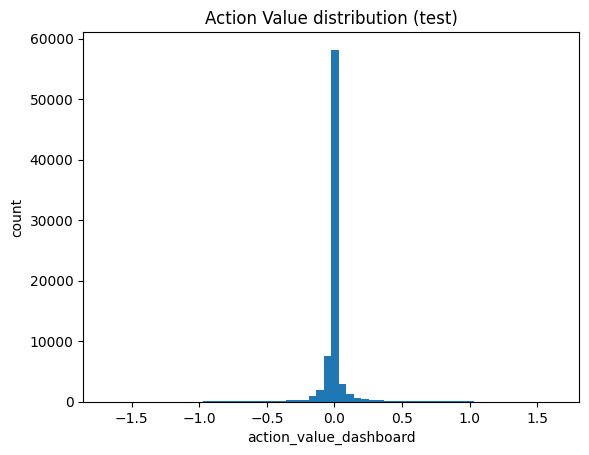

,action_value_dashboard
player_name,
Ángel Fabián Di María Hernández,18.672237
Lionel Andrés Messi Cuccittini,17.230932
Kylian Mbappé Lottin,11.267691
Ademola Lookman,10.711997
Cody Mathès Gakpo,7.657840
Julio César Enciso Espínola,6.933026
Omar Marmoush,6.790058
Bukayo Saka,6.350554
Alex Iwobi,5.217897


In [ ]:
import matplotlib.pyplot as plt

vals = test_out["action_value_dashboard"].values
plt.figure()
plt.hist(vals, bins=60)
plt.title("Action Value distribution (test)")
plt.xlabel("action_value_dashboard")
plt.ylabel("count")
plt.show()

top_players = (
    test_out.groupby("player_name")["action_value_dashboard"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)
top_players


In [ ]:
from statsbombpy import sb
sb.competitions()[[
    "competition_id","season_id",
    "competition_name","season_name","country_name"
]]


/usr/local/lib/python3.12/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


,competition_id,season_id,competition_name,season_name,country_name
0,9,281,1. Bundesliga,2023/2024,Germany
1,9,27,1. Bundesliga,2015/2016,Germany
2,1267,107,African Cup of Nations,2023,Africa
3,16,4,Champions League,2018/2019,Europe
4,16,1,Champions League,2017/2018,Europe
...,...,...,...,...,...
70,35,75,UEFA Europa League,1988/1989,Europe
71,53,315,UEFA Women's Euro,2025,Europe
72,53,106,UEFA Women's Euro,2022,Europe
73,72,107,Women's World Cup,2023,International


In [ ]:
test_out[
    ["start_x", "start_y", "end_x", "end_y"]
].describe()

test_out[
    (test_out["end_x"] < 1) |
    (test_out["end_x"] > 119)
][["type_name","start_x","end_x"]].head(20)



,type_name,start_x,end_x
1,Ball Receipt*,52.0,0.0
4,Ball Receipt*,36.9,0.0
7,Ball Receipt*,25.3,0.0
9,Pressure,92.2,0.0
11,Ball Receipt*,19.3,0.0
14,Ball Receipt*,35.8,0.0
17,Ball Receipt*,18.2,0.0
20,Pressure,70.2,0.0
21,Ball Receipt*,69.6,0.0
23,Ball Receipt*,48.8,0.0
